## 2 Data Wrangling<a id='2_Data_Wrangling'></a>
* [2 Data wrangling](#2_Data_wrangling_introduction)
  * [2.1 Introduction](#2.1_Introduction)
  * [2.3 Product Data Exploration](#2.3_Product)
  * [2.4 Sales Data Exploration](#2.4_Sales)
 * [2.7 Summary](#2.7_Summary)

## Introduction <a href="#2_1_Introduction"></a>

Next, we will embark on EDA, utilizing visualization techniques and statistical analysis to explore patterns and relationships within the data. We will examine the distribution of products across categories, identify correlations between sales and various attributes, and uncover hidden insights within customer purchase behavior. The goal is to paint a picture of the "before" status of the data to show how much cleaning and imporoving the data quality will help with painting a clearer pitcure of inventory and purchasing behavior.

Let's start with importing the visualization and statistical libraries:

In [2]:
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Statistics
import sklearn
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Word frequency
from collections import Counter
from wordcloud import WordCloud

# Part-of-speech tagging
import spacy

from Levenshtein import distance

print("Libraries Loaded")

Libraries Loaded


## 2.2 Product Data Exploration <a id='2.2_Product'></a>

First, let's get more insight into the product and category data. The description data is where all of the product information is stored. Sunlight started using a new naming convention in descriptions that have *Brand - Product Description - Color - Size"*. And Categories have a similar new layout with parent categories starting off followed by child categories, like *Bikes - Mountain Bikes - Hardtails*.

What are the lengths of the Descriptions and Categories? What are some dominant words?

I want to load the product data and do some initial exploration on the category, brand, size, color, MSRP (the price), and cost fields. I hope to gain a further understanding of Sunlight's products and the distribution of sizes, colors, costs, etc.  


In [4]:
products = pd.read_csv("../data/raw/Products-Mar-18.csv", encoding='latin1')

# Number of documents and categories
print("Number of documents:", len(products))
print("Number of categories:", products["Category"].nunique())

Number of documents: 10000
Number of categories: 238


The goal of this project is to classify the product categories more accurately, so let's look at the top words per category to get a better sense of the data. 

In [5]:
top_words_per_category = {}
for category in products["Category"].unique():
    category_text = " ".join(products[products["Category"] == category]["Description"])
    word_counts = Counter(category_text.split()).most_common(10)
    top_words_per_category[category] = word_counts

print("Top words per category:", top_words_per_category)

Top words per category: {nan: [], 'Parts - Stems': [('-', 7), ('adjustable', 6), ('stem', 6), ('black', 4), ('blendr', 4), ('Stem', 3), ('Bontrager', 3), ('|', 3), ('25.4', 2), ('clamp', 2)], 'Parts - Seatposts': [('-', 26), ('seatpost', 12), ('clamp', 12), ('Part', 8), ('black', 8), ('alloy', 7), ('Seatpost', 7), ('remote', 4), ('dropper', 4), ('silver', 4)], 'Logo Merchandise - Impulse': [('-', 107), ('sunlight', 72), ('Tgt', 68), ('sticker', 65), ('logo', 20), ('Silipint', 19), ('oz.', 16), ('mountain', 11), ('glass', 10), ('16', 9)], 'Clothing - Winter - Street Wear': [('-', 45), ('black', 10), ('hoodie', 9), ('Jones', 7), ("m's", 7), ('organic', 7), ('cotton', 7), ('s', 6), ('Ski', 6), ('&', 6)], 'Logo Merchandise - Clothing - Street Wear': [('-', 334), ('tee', 84), ('sunlight', 50), ('Sunlight', 42), ('hanes', 31), ('xl', 30), ('comfort', 30), ('wash', 30), ('m', 29), ('l', 28)], 'Logo Merchandise - Clothing - Performance/Tech Tee': [('-', 90), ('sunlight', 28), ('logo', 25), ('C

In [6]:
# Filter to include only relevant columns
filtered_data = {category: [word[0] for word in words] for category, words in top_words_per_category.items()}

# Create DataFrame with just Word and Count
df = pd.DataFrame(filtered_data.items(), columns=['Category', 'Word'])
df['Count'] = df.groupby('Category')['Word'].transform('size')  # Count occurrences within each category
for category, words in top_words_per_category.items():
    wordcloud = WordCloud(background_color='white', max_font_size=50, width=800, relative_scaling=0.5).generate(" ".join([word[0] for word in words]))
    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f"Word Cloud for Category: {category}")
    plt.show()


ValueError: We need at least 1 word to plot a word cloud, got 0.

In looking at the categories in detail, there are some brands and sizes that appear as the top words. Previously when looking at those fields, they needed some love as there were misspellings and extra spaces, etc. Let's do a quick clean up to see if we can gather some patterns with the sizes and brands that Sunlight sells. 

In [29]:
brand_list = products['Brand'].value_counts().index.tolist()
print(sorted(brand_list))

[' honey stinger', '1', '100%', '3rd eye', 'aardvark', 'absoluteblack', 'abus', 'acs', 'adventure medical kits', 'airblaster', 'aloe up', 'alpina', 'alternative apparel', 'amazon', 'amon cycling', 'anon', 'arcade', 'arcade belt', 'arcade belts', 'armada', 'armada ', 'atomic', 'auclair', 'avid', 'axiom', "backpacker's pantry", 'bar mitts', 'bca', 'bell', 'bikase', 'bike works', 'black', 'black crows', 'black crows ', 'black ops', 'black pearl', 'black/blue', 'blackburn', 'blizzard', 'blue 84', 'bmc', 'boeshield', 'bolle', 'bondhus', 'bontrager', 'boost oxygen', 'boot doc', 'booyah! bamboo', 'bosch', 'brew city', 'brush research', 'bula', 'burley', 'burton', 'burton ', "buzzy's", 'camelbak', 'campagnolo', 'campangolo', 'candy grind', 'cane creek', 'cap', 'capita', 'capita (c3)', 'capita snowboards', 'cateye', 'cbdmd', 'cg', 'cg habitats', 'challenge', "chamois butt'r", 'champion', 'champion ', 'chromag', 'chums', 'cinelli', 'clarks', 'clif bar', 'club ride', 'club ride apparel', 'coal', 

In [8]:
products['Size'] = products['Size'].str.upper().replace(r"\s+", "").astype('category')
products['Brand'] = products['Brand'].str.lower().replace(r"\s+", "")

I created another notebook that is focused on cleaning up the brands as it ended up being a bigger job than anticipated. You can view that [here](../notebooks/02a-brand-clean-up.ipynb).

In [9]:
# should I move this to stage 1? data cleaning
def clean_brands(df):
    condition = (products['Brand'].isna()) | (products['Brand'].str.strip() == 'NaN') | (products['Brand'].str.strip() == 'nan')
    # Apply the condition to filter rows with empty or NaN brands
    products_filtered = products[condition]
    # Check for at least 3 hyphens in the description
    has_3_hyphens = products_filtered['Description'].str.count('-') >= 3
    # Extract the first word from the description and add it to the brand column
    products_filtered['brand'] = products_filtered[has_3_hyphens]['Description'].str.split().str[0]
    # Combine cleaned rows with original DataFrame
    products.update(products_filtered)
    return products

# Apply the function to your DataFrame
products = clean_brands(products)  # Make a copy to avoid modifying the original

# Now your brand column should be cleaned
print(products)


                                          Category          Brand  \
0                                 Clothing - Socks      bontrager   
1                             Ski Hardgoods - Skis         armada   
2        Accessories - Summer - Clothing - Gloves             NaN   
3                    Clothing - Winter - Outerwear      obermeyer   
4                Accessories - Summer - Rear Racks      bontrager   
...                                            ...            ...   
21391              Clothing - Shorts & Bibs - Mens     fox racing   
21392  Accessories - Winter - Hats, Hoods, Collars  coal headwear   
21393      Accessories - Winter - Gloves & Mittens         armada   
21394       Snowboard Hardgoods - Bindings - Women            uni   
21395    Accessories - Summer - Clothing - Gloves             fox   

                                             Description        Keyword  \
0      SOCK BONTRAGER RACE NO SHOW MEDIUM 40-42 WHITE...      BONTRAGER   
1                    

/var/folders/vx/n4xm54gd5g15czs1d5cvl6_m0000gn/T/ipykernel_27302/4222150947.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_filtered['brand'] = products_filtered[has_3_hyphens]['Description'].str.split().str[0]


In [10]:
brand_list = products['Brand'].value_counts().index.tolist()

Next, let's dive into the patterns of the MSRPs, or prices, of the products to get a sense of what the store sells. 

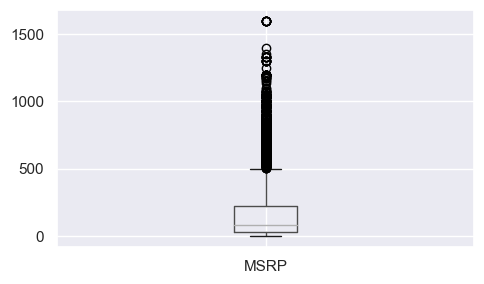

In [11]:
# Find the mean and standard dev
std = products['MSRP'].std()
mean = products['MSRP'].mean()

# Calculate the cutoff
cut_off = std * 3
lower, upper = mean - cut_off,  mean + cut_off

# Trim the outliers
trimmed_df = products[(products['MSRP'] < upper)  & (products['MSRP'] > lower)]

fig, ax = plt.subplots(figsize=(5, 3))  # Adjust overall size
trimmed_df[['MSRP']].boxplot(ax=ax)
plt.tight_layout()
plt.show()

In [12]:
median_price = products['MSRP'].quantile(0.5)  # Quantile at 0.5 is the median
print(f"The median MSRP is ${median_price:.2f}")

The median MSRP is $79.95


Sunlight's Product Prices (Box Plot Analysis):
- **Median Price:** $79.95 (typical product falls near here)

- **Price Range:** $2.50 - $500+ (most products between $50 & $200)

- **Outliers:** A few very affordable or high-end bikes exist.

- **Focus:** Likely a wider selection of moderately priced items (< $200) with some high-end options.


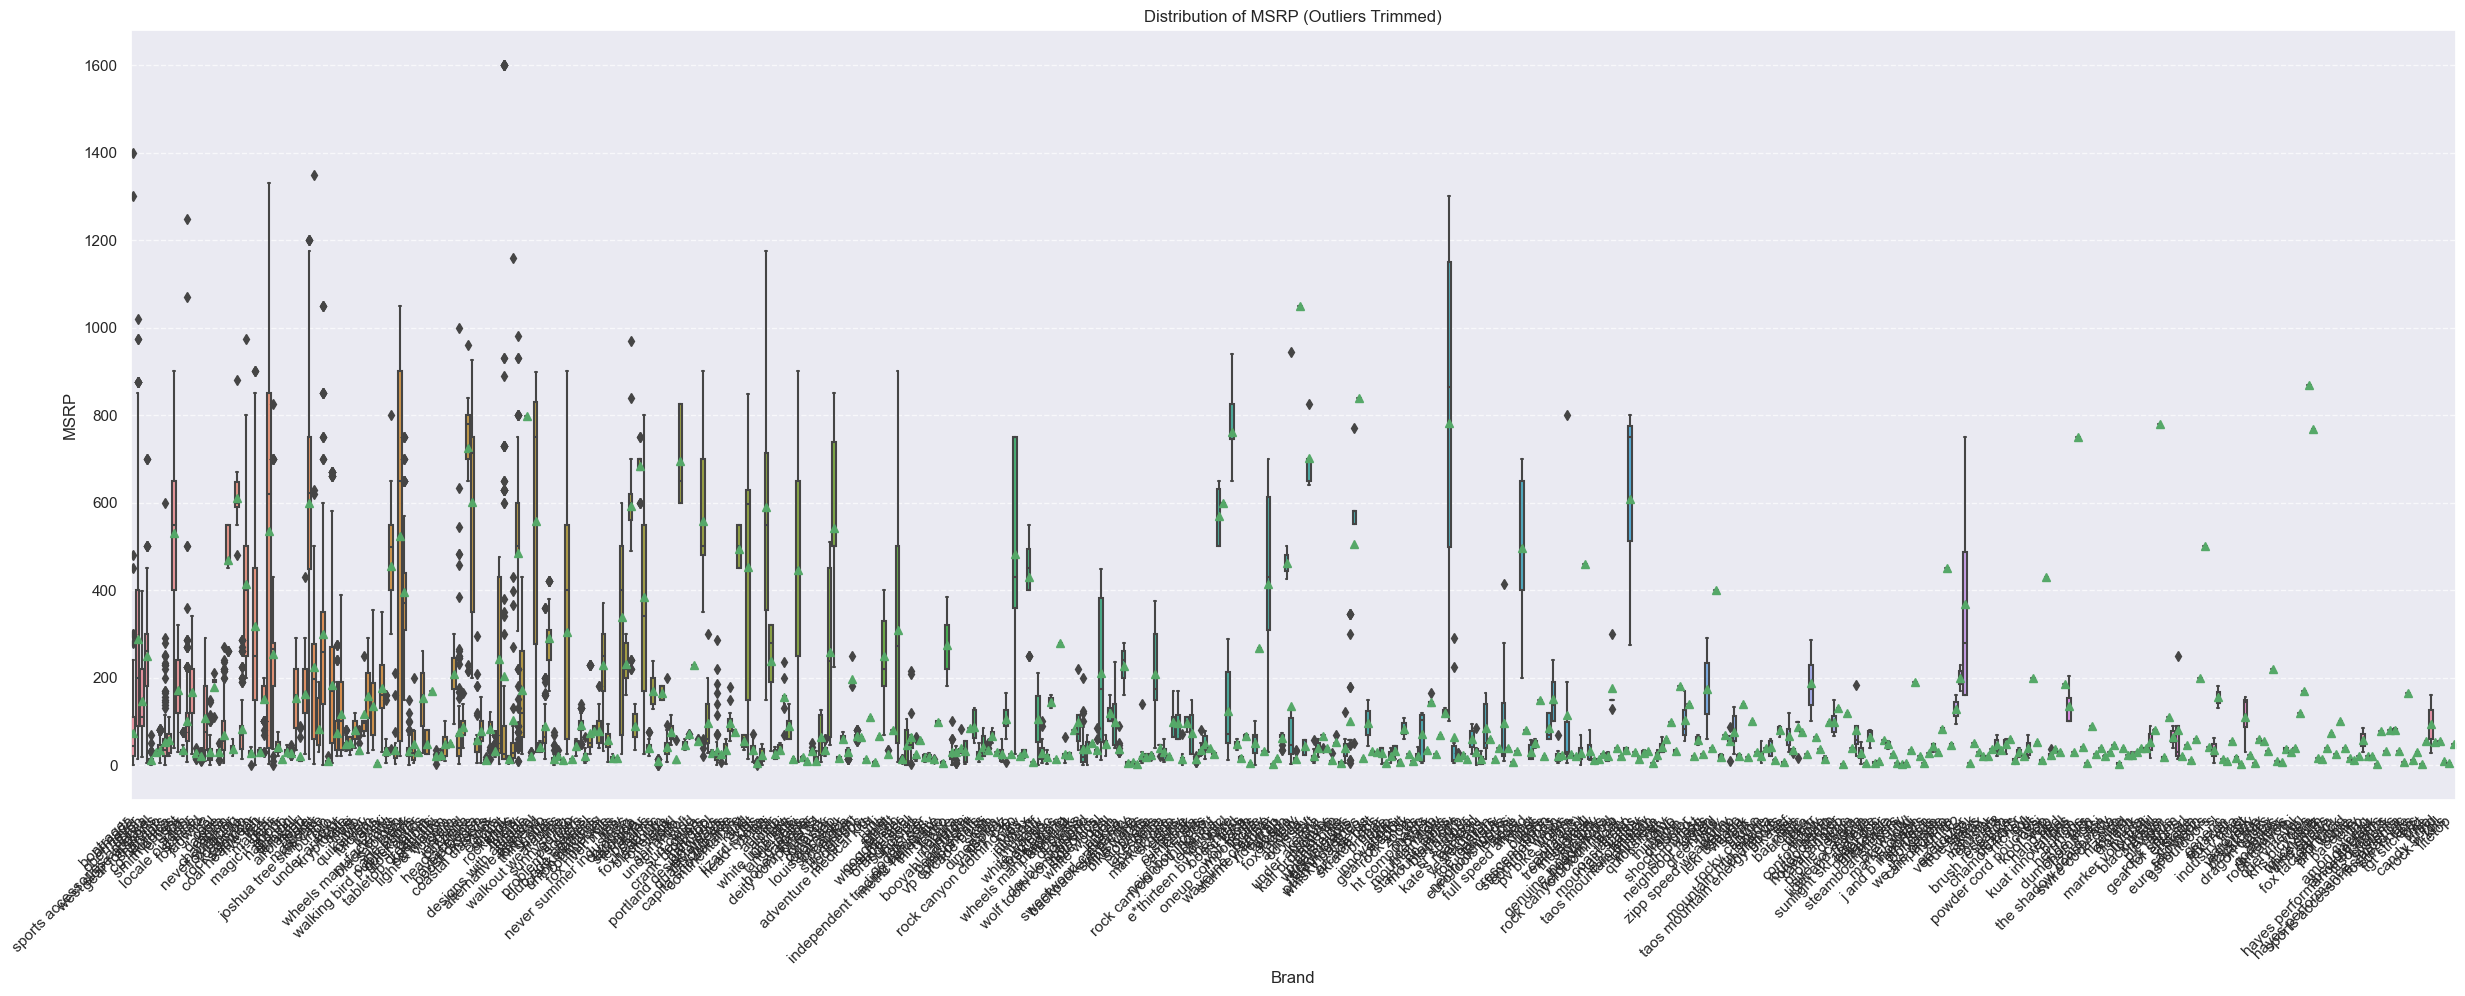

In [13]:
plt.figure(figsize=(30, 10))  # Example with more manageable size

# Create the box plot with Seaborn
sns.boxplot(
    x="Brand",
    y="MSRP",
    showmeans=True,  # Show mean as a diamond
    data=trimmed_df
)

# Customize the plot for better aesthetics
plt.title("Distribution of MSRP (Outliers Trimmed)")
plt.xlabel("Brand")
plt.ylabel("MSRP")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle gridlines

plt.show()


The brands will continue to be cleaned.. this visual will give us a sense of which products are priced the highest and lowest. 

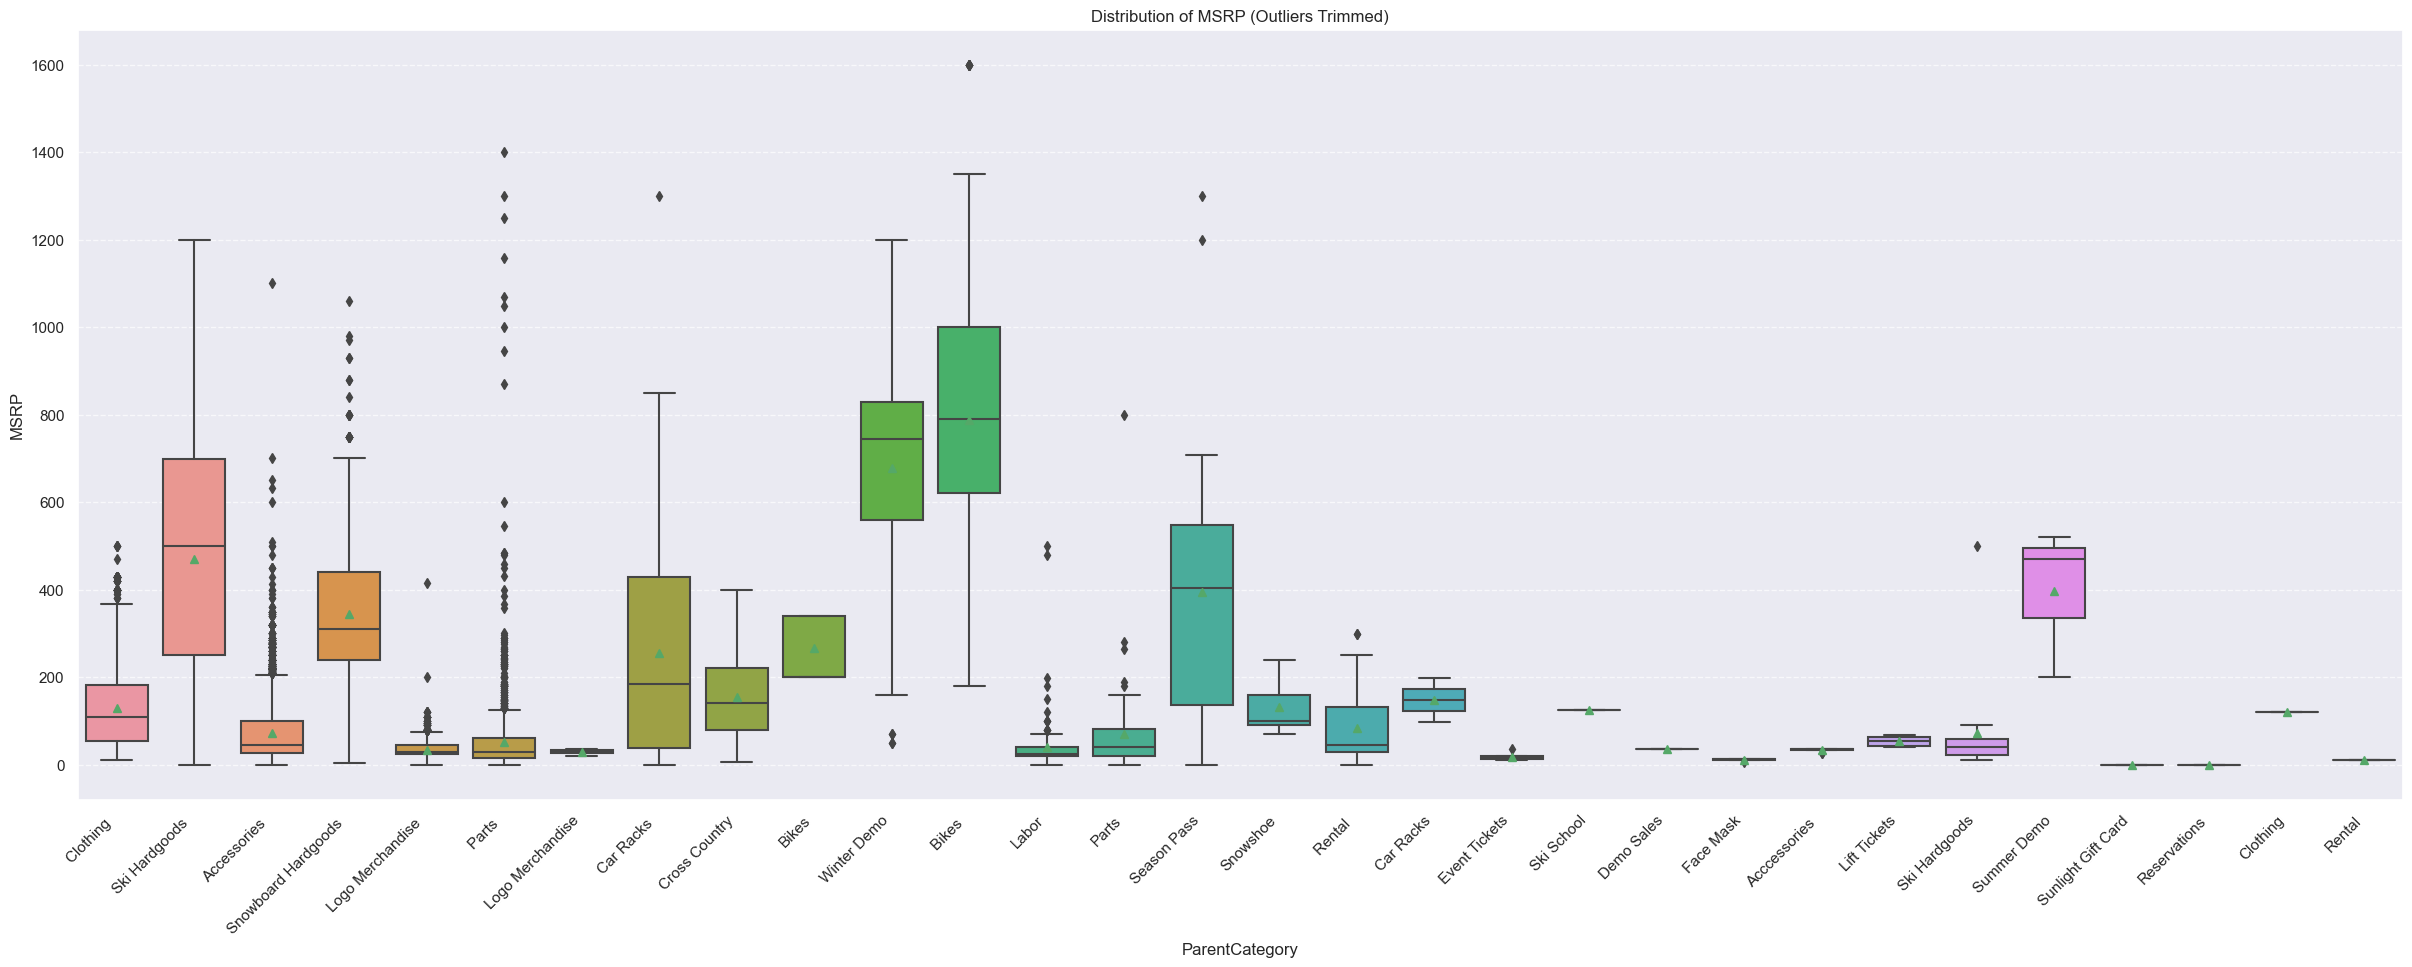

In [14]:
# Set a large figure size (adjust units and values as needed)
plt.figure(figsize=(30, 10))  # Example with more manageable size

# Create the box plot with Seaborn
sns.boxplot(
    x="ParentCategory",
    y="MSRP",
    showmeans=True,  # Show mean as a diamond
    data=trimmed_df
)

# Customize the plot for better aesthetics
plt.title("Distribution of MSRP (Outliers Trimmed)")
plt.xlabel("ParentCategory")
plt.ylabel("MSRP")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle gridlines

plt.show()


As we see above, there are some categories that have large price spreads, like ski hardgoods (skis, boots, bindings), while some are priced quite consistenctly, like face masks, accessories, clothing, etc. 


Next, let's look at what the store quantities look like. This will help us get a sense of what is in inventory.

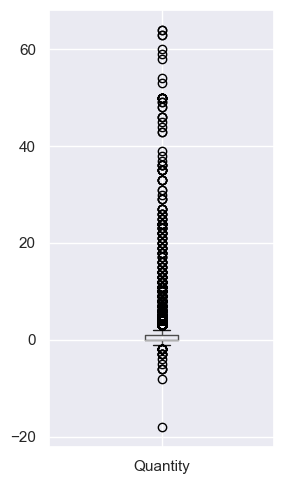

In [15]:
# Find the mean and standard dev
std = products['Quantity'].std()
mean = products['Quantity'].mean()

# Calculate the cutoff
cut_off = std * 3
lower, upper = mean - cut_off,  mean + cut_off

# Trim the outliers
trimmed_df = products[(products['Quantity'] < upper)  & (products['Quantity'] > lower)]

fig, ax = plt.subplots(figsize=(3, 5))  # Adjust overall size
trimmed_df[['Quantity']].boxplot(ax=ax)
plt.tight_layout()
plt.show()

In [16]:
negative_quantity_products = products[products['Quantity'] < 0]
negative_quantity_list = negative_quantity_products['Quantity'].sort_values().head(10)

print(negative_quantity_list)  # List of product quantities less than 0

13473   -18
17160    -8
14840    -6
8513     -6
11510    -6
4044     -5
9874     -4
2656     -3
13045    -3
21355    -3
Name: Quantity, dtype: int64


In [17]:
try:
    product_at_index = products.loc[13473]
    print(product_at_index)  # Show the entire product information
except KeyError:
    print("Product at index 13473 not found")

Category                   Accessories - Summer - Nutrition - Chews
Brand                                                 honey stinger
Description       Honey Stinger - Caffinated Chews - Stingerita ...
Keyword                                               Honey Stinger
UPC                                                    810815026726
MSRP                                                           2.95
Quantity                                                        -18
SKU                                                    HON41160833E
Color                                                           NaN
Size                                                            NaN
StyleNumber                                                   78412
StyleName                                                       NaN
ParentCategory                                         Accessories 
Name: 13473, dtype: object


Maybe someone recieved the box instead of the individual product?

In [18]:
try:
    product_at_index = products.loc[17160]
    print(product_at_index)  # Show the entire product information
except KeyError:
    print("Product at index 17160 not found")

Category                           Parts - Tubeless Accessories
Brand                                                 bontrager
Description       TIRE PART BONTRAGER TLR TIRE SEALANT PER 2 OZ
Keyword                                               BONTRAGER
UPC                                                601842078433
MSRP                                                       4.99
Quantity                                                     -8
SKU                                                      582229
Color                                                       NaN
Size                                                        NaN
StyleNumber                                                 NaN
StyleName                                                   NaN
ParentCategory                                           Parts 
Name: 17160, dtype: object


Another instance where the box could have been recieved instead of the individual packs.

In [19]:
try:
    product_at_index = products.loc[14840]
    print(product_at_index)  # Show the entire product information
except KeyError:
    print("Product at index 14840 not found")

Category          Accessories - Winter - Hats, Hoods, Collars
Brand                                                     NaN
Description                      Kids' Burke Hood Stardust HS
Keyword                                                   NaN
UPC                                              193177727075
MSRP                                                    21.95
Quantity                                                   -6
SKU                                              KID23670929S
Color                                                Stardust
Size                                                       HS
StyleNumber                                            204891
StyleName                                    Kids' Burke Hood
ParentCategory                                   Accessories 
Name: 14840, dtype: object


This one looks like it did not get transferred up to the mountain properly. 

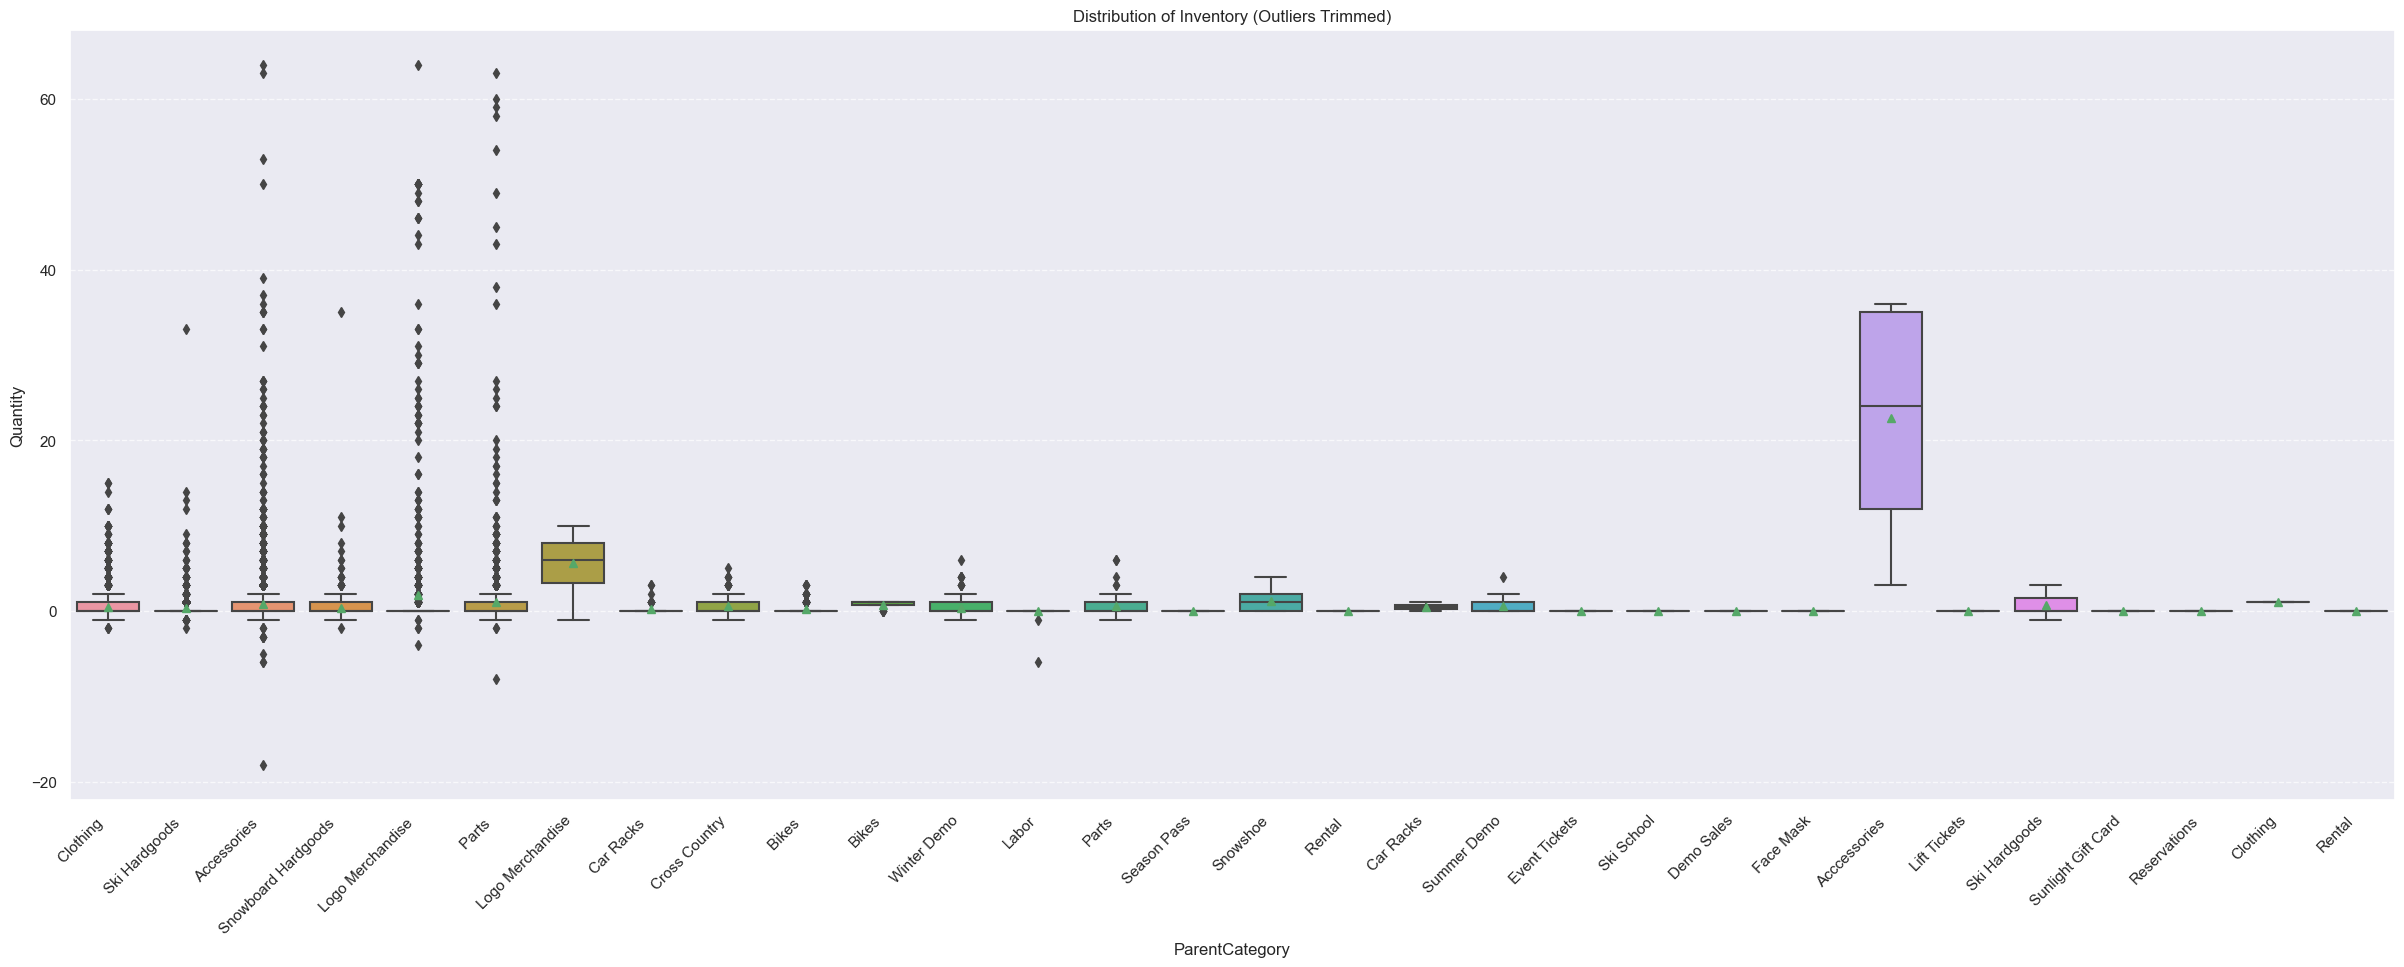

In [20]:
# Set a large figure size (adjust units and values as needed)
plt.figure(figsize=(30, 10))  # Example with more manageable size

# Create the box plot with Seaborn
sns.boxplot(
    x="ParentCategory",
    y="Quantity",
    showmeans=True,  # Show mean as a diamond
    data=trimmed_df
)

# Customize the plot for better aesthetics
plt.title("Distribution of Inventory (Outliers Trimmed)")
plt.xlabel("ParentCategory")
plt.ylabel("Quantity")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle gridlines

plt.show()


This exploration is giving me insight into what I need to fix in the database. I hope to do that before I train the data. I will make all of the adjustments in the point of sales system and then re-run the data for the trainings and maching learning.

## Products Sizes

Now, let's look at the sizing of these products. 

In [21]:
products['Size'].value_counts().index.tolist()

['M',
 'L',
 'S',
 'XL',
 'OS',
 'OSFA',
 'XS',
 'OSFM',
 'XXL',
 'MEDIUM',
 'LARGE',
 '8',
 'SMALL',
 '10',
 '9',
 '12',
 '7',
 '11',
 '9.5',
 '6',
 '8.5',
 'O/S',
 '26.5',
 '10.5',
 '1SZ',
 '7.5',
 '27.5',
 '25.5',
 'SM',
 '24.5',
 '2XL',
 'MD',
 '28.5',
 '158',
 '5',
 '156',
 'S/M',
 'LG',
 '155',
 '23.5',
 '160',
 '11.5',
 '13',
 '265',
 '29.5',
 'X-LARGE',
 '152',
 '120',
 'L/XL',
 '163',
 '177',
 '115',
 '172',
 '151',
 '154',
 '100',
 '6.5',
 '30',
 '275',
 '130',
 '34',
 'ONE SIZE',
 '255',
 '148',
 '32',
 '171',
 '36',
 '110',
 '145',
 '165',
 '125',
 '285',
 '28',
 '159',
 '149',
 '4',
 '157',
 '26/26.5',
 '90',
 '38',
 'YL',
 'S\\M',
 '150',
 '170',
 '166',
 '245',
 'YS',
 '25/25.5',
 '175CM',
 '164',
 '235',
 '176',
 '180',
 'M\\L',
 '162',
 '161',
 '153',
 'XS/8',
 '14',
 '183',
 '142',
 '144',
 'M/12',
 'L/14',
 '190CM',
 'S/10',
 '140',
 'YM',
 '295',
 'YOUTH M',
 'XL/16',
 '27/27.5',
 '135',
 'M/L',
 '143',
 '26',
 'UNIV',
 'L90',
 'YOUTH S',
 '184',
 '40',
 '146',
 'L1

In [22]:
def standardize_size(size):
  """
  Standardizes a clothing size label.

  Args:
      size: The size label to be standardized (string).

  Returns:
      The standardized size label (string).
  """
  size_map = {
      "XSMALL": "XS",
      "X-SMALL": "XS",
      "X-LARGE": "XXL",
      "2XL": "XXL",
      "2X": "XXL",
      "SMALL ": "S",
      "S\\M": "S/M",
      "MED": "M",
      "MEDIUM": "M",
      "M\\L": "M/L",
      "LRG": "L",
      "LARGE": "L",
      "XTRA": "XL",
      "OS": "OS",
      "UA": "OS",
      "ONE SIZE": "OS",
      "UNIV": "OS",
      "OSFM": "OS",
      "1SZ FITALL": "OS",
      "ADULT": "",  # Replace with desired value (e.g., "NA")
      "": "",  # Replace with desired value (e.g., "NA")
      "JR OSFA": "YOUTH OS",
      "YOUTH X-SMALL": "YOUTH XS",
      "YXL": "YOUTH XL",
      "YL": "YOUTH L",
      "YM": "YOUTH M",
      "YS": "YOUTH S",
      "YOUTH SMALL": "YOUTH S"
  }
  return size_map.get(size.upper(), size.upper())  # Use upper case for case-insensitive matching

products['Size'] = products['Size'].apply(standardize_size)

# Optional: Filter unwanted sizes
products = products[~products['Size'].isin(["SKI", "SHOE", "OZ"])]  # Exclude unwanted sizes

unique_counts = products['Size'].value_counts()
print(unique_counts)


Size
M               2098
L               1915
S               1533
XL               973
OS               840
                ... 
100/122            1
7 SP RIGHT         1
YTH 4T             1
420                1
10SP, 11-42T       1
Name: count, Length: 1294, dtype: int64


In looking at the size field, I did not realize how many different measurements and sizes we had in the store. We have T-Shirt and clothing sizes for women, men and kids. And then we have shoe and boot sizes for women, men, and kids. We also have ski, pole and snowboard lengths, oz of containers like gels and lubes. The list goes on for all the different sizes we have in the store! I will focus on the clothing and bike sizes for this exploration (S, M, L). 

In [23]:
import matplotlib.pyplot as plt
from collections import Counter

def extract_sizes(data):
    sizes = []
    for item in data:
        for size in ["YOUTH L", "YOUTH S", "YOUTH M", "OS", "XXL", "XL", "L", "M", "S", "XS"]:
            # Check if "size" is a substring, ignoring case
            if size in item:
                sizes.append(size)
                break  # Only extract one size per item

    # Count occurrences of each size
    size_counts = Counter(sizes)
    
    # Sort the sizes by predefined order
    sorted_sizes = ["XS", "S", "M", "L", "XL", "XXL", "YOUTH S", "YOUTH M", "YOUTH L", "OS"]
    sorted_size_counts = {size: size_counts[size] for size in sorted_sizes if size in size_counts}

    # Create histogram
    plt.figure(figsize=(10, 6))  # Increase figure size
    plt.bar(sorted_size_counts.keys(), sorted_size_counts.values(), color='skyblue')
    plt.xlabel("Sizes")
    plt.ylabel("Count")
    plt.title("Distribution of Extracted Sizes")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

# Extract sizes from non-numeric data
extracted_sizes = extract_sizes(non_numeric_sizes.tolist())

# Further analysis can be done here using the extracted_sizes list


NameError: name 'non_numeric_sizes' is not defined

Well the initial exploration of product data showed the distibution of prices, sizes, and categories of producst that the Sunlight store offers. It looks like there is lots of oppurtunity for cleaning up the size, brand, and color fields further to gain more insights into which colors and sizes are the most popular. Stay tuned!

## 2.2 Sales Data Integration <a id='2.2_Sales'></a>

We have gotten a glimpse at the product descriptions and categories. Let's look at how products interact with sales data. The goal of this data exploration is to create a "before" scene of the data -- like how well each category sells, and how quickly its sell. Sunlight hopes to see if cleaning up the data and making sure the products are in the correct categories affects the numbers and reporting for how well and quickly products sell. 

In [ ]:
# Load the data
sales_csv = "../data/raw/Sales 1-3-2024.csv"
sales_category_excel = "../data/raw/Sales_By_Category_20231226_1648.xlsx"
sales_history_csv = "../data/raw/Sales/2023 - Sunlight Ski and Bike Shop.csv"

sales = pd.read_csv(sales_history_csv,  encoding='latin-1')  # Replace with your actual CSV file path
sales.head()

In [ ]:
# Merge product and sales data (assuming a common identifier)
df = products.merge(sales, on="Description", how="left", suffixes=('_sales', '_product'))
df.isnull().sum()

In [ ]:
def z_score_outliers(df, column):
  """
  Identifies outliers in a DataFrame column using the z-score method.

  Args:
      df: The pandas DataFrame.
      column: The name of the column containing numerical data.

  Returns:
      A DataFrame containing only the outlier rows.
  """
  mean = df[column].mean()
  std = df[column].std()
  threshold = 3
  # Filter outliers using logical AND (&) instead of OR
  outliers = df[(df[column] - mean) / std > threshold & (df[column] - mean) / std < -threshold]
  return outliers

def iqr_outliers(df, column):
  """
  Identifies outliers in a DataFrame column using the Interquartile Range (IQR) method.

  Args:
      df: The pandas DataFrame.
      column: The name of the column containing numerical data.

  Returns:
      A DataFrame containing only the outlier rows.
  """
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  # Filter outliers using logical AND (&)
  outliers = df[(df[column] < lower_bound) & (df[column] > upper_bound)]
  return outliers


In [ ]:
# view profit/margin per category... (eventually, churn or speed recieved and then sold)

for col in list(df.columns):
    df[col].plot(kind = 'hist', title = col)
    plt.show()

In [ ]:
# Example: Analyze sales trends by month
df["Month"] = pd.to_datetime(df["SaleDate"]).dt.month_name()
calendar = ["January","February","March","April","May","June","July",
            "August","September","October","November","December"]
sns.barplot(x="Month", y="Sales", data=df, order=calendar)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Analyze profit by month per category
df["Month"] = pd.to_datetime(df["SaleDate"]).dt.month_name()
calendar = ["January","February","March","April","May","June","July",
            "August","September","October","November","December"]
sns.barplot(x="Month", y="Profit", data=df, order=calendar, palette='Set2')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [ ]:
null_values_df = df[df.isnull().any(axis=1)]
print(null_values_df.head())

These are products that we have not sold yet, so they are returning "NaN". Because they are null, I probably should have done a left join to sales-- instead of on products. I will go back and join the tables the better way. 

In [ ]:
# df = sales.merge(products, on="Description", how="left", suffixes=('_sales', '_product'))

In [ ]:
df.groupby('Month').sum()

In [ ]:
# Create the stacked bar chart with legend outside
ax = sns.catplot(
    x="Month",
    y="Profit",
    hue="ParentCategory",
    kind="bar",
    data=df,
    order=calendar,  # Assuming months ordered correctly
    height=6,
    aspect=2,
    palette="Set3",
    legend=False,  # Initially hide legend
    zorder=10,  # Ensure bars are drawn on top of grid and edges
    edgecolor="none",  # Remove bar outlines
)

# Move legend outside the plot with clear placement
plt.legend(title="Parent Category", loc='upper left', bbox_to_anchor=(1.05, 1))

# Other formatting and clarity enhancements
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Quantity Sold")
plt.title("Quantity Sold by Month, Segmented by Parent Category")
plt.tight_layout()
plt.show()

#grid for bar charts. Total Overall: Line graph per month by year (Avg) OR most recent by year; totals by year; OVERALL SALES TRENDS; by parent category
#percent versus absolute values; less than 1 percent not worth looking at

Oh no. There are two "Logo Merchandise" and "Bike" categories.

In [ ]:
sns.histplot(x="Profit", hue="ParentCategory", data=df, multiple="stack", bins=100)

In [ ]:
# Create a subplot grid
fig, axes = plt.subplots(len(df['ParentCategory'].unique()), figsize=(12, 6))

# Iterate through each category and create a bar plot
for i, category in enumerate(df['ParentCategory'].unique()):
    subset = df[df['ParentCategory'] == category]  # Subset data for the category
    sns.barplot(x="Month", y="Profit", data=subset, order=calendar, palette='Set2', ax=axes[i])
    axes[i].set_title(f"Profit by Month for {category}")
    
# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Reduce label font size
plt.tick_params(axis='x', labelsize=8)  # Adjust font size as needed

# Adjust spacing and show the plot
# plt.tight_layout()
plt.show()

In [ ]:
# Example: Analyze sales trends by month
df["Month"] = pd.to_datetime(df["SaleDate"]).dt.month_name()
calendar = ["January","February","March","April","May","June","July",
            "August","September","October","November","December"]

palette = ["red", "orange", "yellow", "green", "blue"]

# Set the palette for future plots
sns.set_palette('RdBu')

sns.barplot(x="Month", y="Profit", data=df, order=calendar)

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Explore relationships using scatter plots
sns.relplot(x="MSRP_sales", y="Quantity_sales", data=df)
plt.show()

In [ ]:
# Compare distributions with boxplots
sns.boxplot(x="Brand", y="Quantity_sales", data=df)
plt.tight_layout()
plt.xticks(rotation=90)
plt.tick_params(labelsize=3)
plt.show()

In [ ]:
# Handle missing values (replace with your preferred method)
df.fillna(method="ffill", inplace=True)  # Forward fill missing values

In [ ]:
# Get descriptive statistics for numerical features
numerical_features = df.select_dtypes(include=["int64", "float64"])
print(numerical_features.describe())

# Create frequency tables for categorical features
categorical_features = df.select_dtypes(include=["object"])
for col in categorical_features:
    print(df[col].value_counts())

# Visualize numerical feature distribution with histograms
numerical_features.hist(figsize=(10, 10))
plt.subplots_adjust(bottom=0.1)  # Adjust spacing for better readability
plt.show()

In [ ]:
# Example: Analyze sales trends by month
df["Month"] = pd.to_datetime(df["SaleDate"]).dt.month_name()
sns.barplot(x="Month", y="Quantity_sales", data=df)
plt.show()

In [ ]:
# Example: Identify top-selling products
top_selling = df.nlargest(10, "Quantity_sales")

# Create the bar plot
sns.barplot(x="Description", y="Quantity_sales", data=top_selling)

# Rotate and format y labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for longer descriptions
plt.ylabel("Quantity Sold")  # Set clear y-axis label
plt.tight_layout()  # Adjust spacing for readability

# Additional enhancements (optional)
plt.subplots_adjust(left=0.2)  # Adjust left margin for more label space
plt.yscale('log')  # Use log scale for large quantity differences

plt.show()

In [ ]:
# Example: Identify top-selling products
top_selling = df.nlargest(10, "Profit")

# Create the bar plot
sns.barplot(x="Description", y="Profit", data=top_selling)

# Rotate and format y labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for longer descriptions
plt.ylabel("Profit")  # Set clear y-axis label
plt.tight_layout()  # Adjust spacing for readability

# Additional enhancements (optional)
plt.subplots_adjust(left=0.2)  # Adjust left margin for more label space
plt.yscale('log')  # Use log scale for large quantity differences

plt.show()

In [ ]:
# Example: Identify top-selling products
top_selling = df.nlargest(10, "Margin")

# Create the bar plot
sns.barplot(x="Description", y="Margin", data=top_selling)

# Rotate and format y labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for longer descriptions
plt.ylabel("Margin")  # Set clear y-axis label
plt.tight_layout()  # Adjust spacing for readability

# Additional enhancements (optional)
plt.subplots_adjust(left=0.2)  # Adjust left margin for more label space
plt.yscale('log')  # Use log scale for large quantity differences

plt.show()

In [ ]:
# Remember to replace placeholders with your specific data and analysis goals
sns.histplot(data=df, x="Discount")
plt.xlabel("Discount (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Discounts in Sales Data")
plt.show()

In [ ]:
# Calculate correlations with a heatmap
corrmat = sales.corr()
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax,fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Match Data Feature Correlation for Sales', fontsize=14)

In [ ]:
sns.pairplot(df, hue='Category', palette='Set1',
            diag_kind='kde',  # Add kernel density estimates
            grid=False, xticks_rotation=45,
            fig_size=(12, 8))  # Adjust figure size

plt.subplots_adjust(top=0.92)  # Adjust top margin for legend outside

plt.legend(title="Category", loc='upper left', bbox_to_anchor=(1.1, 1))

plt.tight_layout()
plt.show()

In [ ]:
# Add a date column if not present
df["SaleDate"] = pd.to_datetime(df["SaleDate"])

# Group data by date and calculate discounted sales count
discounted_per_date = df[df["Discount"] > 0].groupby("SaleDate")["Discount"].count().reset_index()

# Create a line plot
sns.lineplot(x="SaleDate", y="Discount", data=df)
plt.xlabel("Sale Date")
plt.ylabel("Discounted Sales Count")
plt.title("Discounted Sales Frequency Over Time")
plt.show()

In [ ]:
sns.stripplot(data=sales,
            x='Category',
            y='Month', s=5)
plt.xlabel('Category')
plt.ylabel('Month')
sns.despine()
# # plt.savefig('casualty breakdown')
plt.show()

## Summary<a id="2.3_Summary"></a>

Well, it looks like these data sets needed a lot of cleanup. We were able to get some insights into the products and sales of sunlight. In creating a "before" look at the sales data by category, we can see how useful adjusting the product categories are to getting more accurate reports on costs and sales. 